# 2D Grid Exploration

Map grade level across a 2D grid of (α, β) coordinates to visualize where the discontinuity lives in activation space.

**Method:**
- Prompt: "Can you explain quantum mechanics please?"
- Measure FK grade level at each (α, β)

**Goal:** Visualize grade_level(α, β) as a heatmap. Where is the discontinuity from the 1D sweep? Is it a vertical line, a curve, or something weirder?

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import textstat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Configuration

In [ ]:
MODEL_NAME = "unsloth/Llama-3.2-3B-Instruct"
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
STEERING_LAYER = 27

# Grid configuration
TEST_PROMPT = "Can you explain quantum mechanics please?"
ALPHA_MIN = -1.0
ALPHA_MAX = 1.0
ALPHA_STEP = 0.01
BETA_MIN = -1.0
BETA_MAX = 1.0
BETA_STEP = 0.01

# Generation parameters
MAX_NEW_TOKENS = 200
BATCH_SIZE = 1024  # Generate 1024 points simultaneously for better GPU utilization

print(f"Device: {DEVICE}")
print(f"Grid size: {int((ALPHA_MAX-ALPHA_MIN)/ALPHA_STEP + 1)} × {int((BETA_MAX-BETA_MIN)/BETA_STEP + 1)} = {int((ALPHA_MAX-ALPHA_MIN)/ALPHA_STEP + 1) * int((BETA_MAX-BETA_MIN)/BETA_STEP + 1)} points")
print(f"Batch size: {BATCH_SIZE}")

Device: cuda
Grid size: 201 × 201 = 40401 points
Batch size: 4096


## Load model and vectors

In [4]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() or torch.backends.mps.is_available() else torch.float32,
    device_map="auto",
)
model.eval()
print("✓ Model loaded")

Loading model: unsloth/Llama-3.2-3B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Model loaded


In [5]:
# Load vectors
vectors = torch.load('vectors/complexity_vectors.pt')
v_complexity = vectors[STEERING_LAYER]
v_perpendicular = torch.load('vectors/perpendicular_vector.pt')

print(f"V_complexity shape: {v_complexity.shape}, L2 norm: {torch.norm(v_complexity).item():.4f}")
print(f"V_perpendicular shape: {v_perpendicular.shape}, L2 norm: {torch.norm(v_perpendicular).item():.4f}")

# Verify orthogonality
dot_product = torch.dot(v_complexity, v_perpendicular).item()
print(f"Dot product (should be ~0): {dot_product}")

V_complexity shape: torch.Size([3072]), L2 norm: 9.8750
V_perpendicular shape: torch.Size([3072]), L2 norm: 9.8750
Dot product (should be ~0): 0.00066375732421875


## Steering functions

In [6]:
def generate_batch_with_steering(prompt, alpha_beta_pairs):
    """
    Generate text for multiple (α, β) pairs simultaneously.
    
    Args:
        prompt: The text prompt
        alpha_beta_pairs: List of (alpha, beta) tuples
    
    Returns:
        List of generated texts
    """
    batch_size = len(alpha_beta_pairs)
    
    # Format prompts (same for all)
    messages = [{"role": "user", "content": prompt}]
    formatted_prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # Tokenize and create batch
    inputs = tokenizer([formatted_prompt] * batch_size, return_tensors="pt", padding=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Compute steering vectors for entire batch
    steering_vectors = torch.stack([
        (alpha * v_complexity + beta * v_perpendicular).to(model.device)
        for alpha, beta in alpha_beta_pairs
    ])  # Shape: [batch_size, hidden_dim]
    
    # Define batched steering hook
    def steering_hook(module, input, output):
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        
        # Apply different steering vector to each batch element
        # hidden_states shape: [batch_size, seq_len, hidden_dim]
        # steering_vectors shape: [batch_size, hidden_dim]
        # We broadcast the steering across seq_len
        steered = hidden_states + steering_vectors.unsqueeze(1)  # Add seq_len dimension
        
        if isinstance(output, tuple):
            return (steered,) + output[1:]
        else:
            return steered
    
    # Register hook
    hook_handle = model.model.layers[STEERING_LAYER].register_forward_hook(steering_hook)
    
    try:
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                do_sample=False,  # Greedy decoding for reproducibility
            )
        # Decode all outputs
        full_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    finally:
        hook_handle.remove()
    
    # Extract assistant responses
    generated_texts = []
    for full_text in full_texts:
        if "<|start_header_id|>assistant<|end_header_id|>" in full_text:
            generated_text = full_text.split("<|start_header_id|>assistant<|end_header_id|>", 1)[1]
            generated_text = generated_text.lstrip('\n')
        else:
            generated_text = full_text[len(prompt):].strip()
        
        # Clean up special tokens
        for token in ["<|eot_id|>", "<|end_of_text|>", "<|im_end|>", "<|endoftext|>"]:
            if token in generated_text:
                generated_text = generated_text.split(token)[0]
        
        generated_texts.append(generated_text.strip())
    
    return generated_texts


def analyze_text(text):
    """Compute FK grade level and other metrics."""
    if not text or len(text.strip()) < 10:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }
    
    try:
        return {
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'word_count': textstat.lexicon_count(text, removepunct=True),
            'sentence_count': textstat.sentence_count(text),
        }
    except:
        return {
            'flesch_kincaid_grade': 0.0,
            'word_count': 0,
            'sentence_count': 0,
        }

print("✓ Batched functions defined")

✓ Batched functions defined


## Run the 2D grid sweep

In [7]:
start_time = datetime.now()
print(f"Starting batched 2D grid sweep at {start_time.strftime('%H:%M:%S')}")
print(f"Grid: α ∈ [{ALPHA_MIN}, {ALPHA_MAX}], β ∈ [{BETA_MIN}, {BETA_MAX}]")
print(f"Batch size: {BATCH_SIZE}\n")

alphas = np.arange(ALPHA_MIN, ALPHA_MAX + ALPHA_STEP/2, ALPHA_STEP)
betas = np.arange(BETA_MIN, BETA_MAX + BETA_STEP/2, BETA_STEP)

# Create all (alpha, beta) pairs
all_pairs = [(alpha, beta) for alpha in alphas for beta in betas]
total_points = len(all_pairs)

results = []

# Process in batches
for batch_start in range(0, total_points, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, total_points)
    batch_pairs = all_pairs[batch_start:batch_end]
    
    print(f"[{batch_start+1}-{batch_end}/{total_points}] Processing batch of {len(batch_pairs)} points...", end=" ")
    
    # Generate for entire batch
    batch_texts = generate_batch_with_steering(TEST_PROMPT, batch_pairs)
    
    # Analyze each result
    for (alpha, beta), text in zip(batch_pairs, batch_texts):
        metrics = analyze_text(text)
        results.append({
            'alpha': alpha,
            'beta': beta,
            'generated_text': text,
            **metrics
        })
    
    # Show progress with grade levels
    gls = [analyze_text(t)['flesch_kincaid_grade'] for t in batch_texts]
    print(f"GL range: {min(gls):.1f}-{max(gls):.1f}")

df = pd.DataFrame(results)
end_time = datetime.now()
elapsed = (end_time - start_time).total_seconds() / 60

print(f"\n✓ Grid sweep complete in {elapsed:.1f} minutes")
print(f"Average time per point: {elapsed*60/total_points:.2f} seconds")

Starting batched 2D grid sweep at 21:04:29
Grid: α ∈ [-1.0, 1.0], β ∈ [-1.0, 1.0]
Batch size: 4096

[1-4096/40401] Processing batch of 4096 points... 

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


GL range: 11.8-13.8
[4097-8192/40401] Processing batch of 4096 points... GL range: 11.9-13.8
[8193-12288/40401] Processing batch of 4096 points... GL range: 13.2-13.8
[12289-16384/40401] Processing batch of 4096 points... GL range: 12.8-14.4
[16385-20480/40401] Processing batch of 4096 points... GL range: 10.8-14.5
[20481-24576/40401] Processing batch of 4096 points... GL range: 10.4-14.5
[24577-28672/40401] Processing batch of 4096 points... GL range: 10.4-14.5
[28673-32768/40401] Processing batch of 4096 points... GL range: 10.3-14.4
[32769-36864/40401] Processing batch of 4096 points... GL range: 10.3-14.1
[36865-40401/40401] Processing batch of 3537 points... GL range: 11.2-13.7

✓ Grid sweep complete in 6.0 minutes
Average time per point: 0.01 seconds


## Visualize 2D heatmap

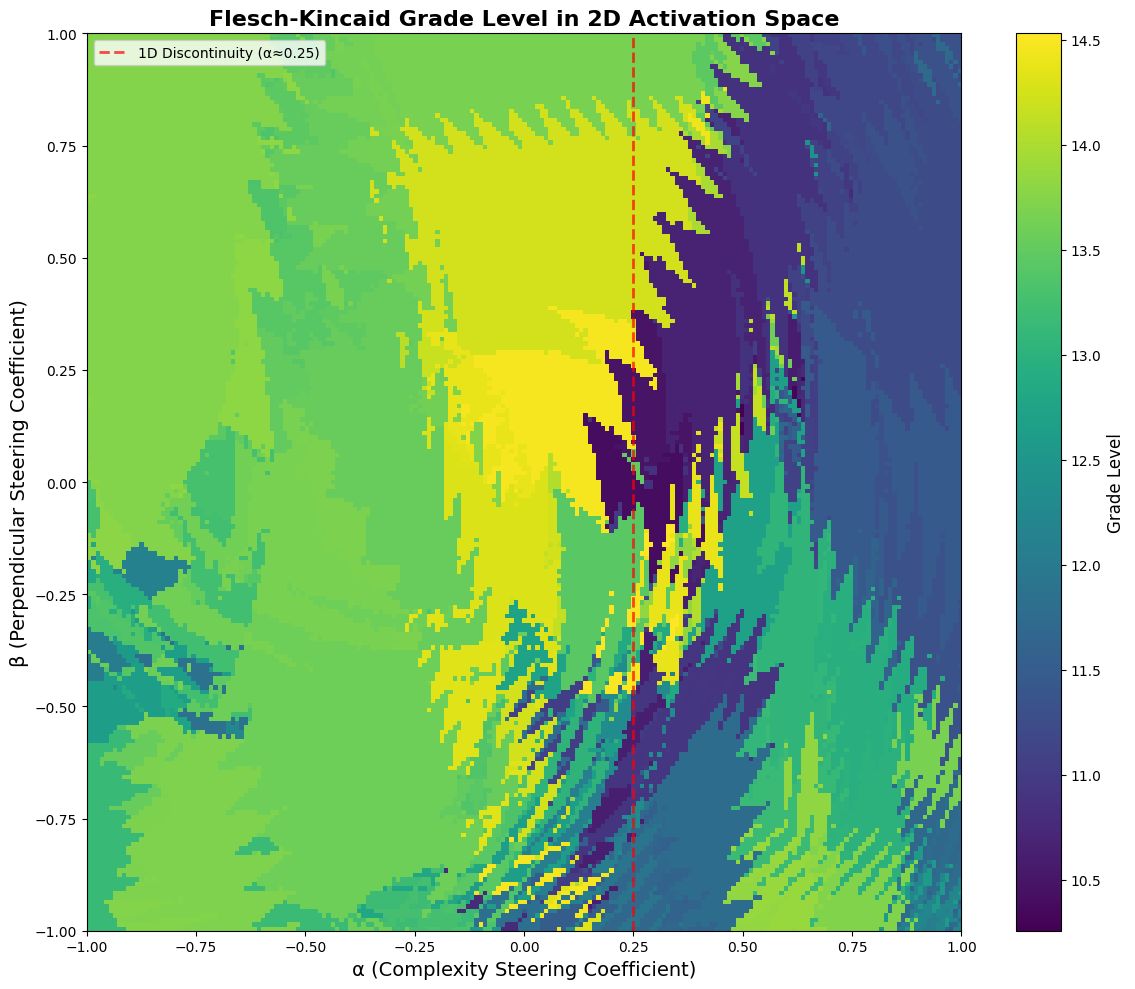


Grade level range: 10.3 to 14.5


In [8]:
# Reshape data into 2D grid for heatmap
pivot = df.pivot(index='beta', columns='alpha', values='flesch_kincaid_grade')

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(pivot, cmap='viridis', aspect='auto', origin='lower',
               extent=[ALPHA_MIN, ALPHA_MAX, BETA_MIN, BETA_MAX])

# Overlay the discontinuity from 1D data (α ≈ 0.25)
ax.axvline(0.25, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1D Discontinuity (α≈0.25)')

# Labels and formatting
ax.set_xlabel('α (Complexity Steering Coefficient)', fontsize=14)
ax.set_ylabel('β (Perpendicular Steering Coefficient)', fontsize=14)
ax.set_title('Flesch-Kincaid Grade Level in 2D Activation Space', fontsize=16, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Grade Level', fontsize=12)

# Legend
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

print(f"\nGrade level range: {df['flesch_kincaid_grade'].min():.1f} to {df['flesch_kincaid_grade'].max():.1f}")

## Save results

In [9]:
df.to_csv('data/2d_grid_results.csv', index=False)
print("✓ Saved to data/2d_grid_results.csv")

✓ Saved to data/2d_grid_results.csv


## 3D Surface Visualization

Visualize grade level as a 3D surface over the (α, β) plane.

Load data from CSV so this can be run standalone.

Loaded 40401 data points from CSV
Alpha range: [-1.00, 1.00]
Beta range: [-1.00, 1.00]
Grade level range: [10.26, 14.53]



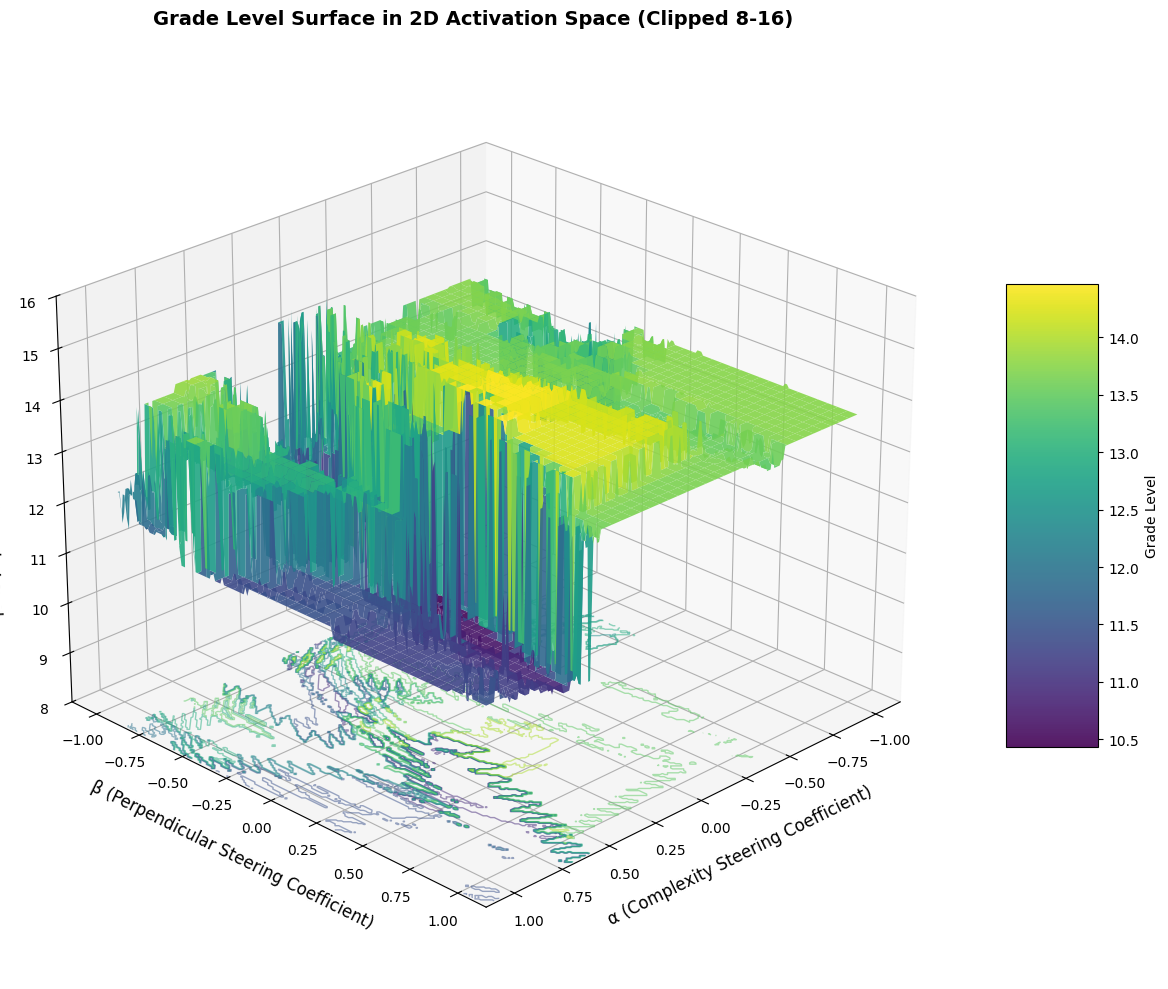

Surface statistics (clipped to 8-16):
  Min GL: 10.26
  Max GL: 14.53
  Mean GL: 12.98
  Std GL: 1.18

Original range before clipping: 10.26 to 14.53


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data from CSV
df = pd.read_csv('data/2d_grid_results.csv')

print(f"Loaded {len(df)} data points from CSV")
print(f"Alpha range: [{df['alpha'].min():.2f}, {df['alpha'].max():.2f}]")
print(f"Beta range: [{df['beta'].min():.2f}, {df['beta'].max():.2f}]")
print(f"Grade level range: [{df['flesch_kincaid_grade'].min():.2f}, {df['flesch_kincaid_grade'].max():.2f}]\n")

# Reshape data for 3D surface
pivot = df.pivot(index='beta', columns='alpha', values='flesch_kincaid_grade')
X = pivot.columns.values
Y = pivot.index.values
X_grid, Y_grid = np.meshgrid(X, Y)
Z = pivot.values

# Clip Z values to [8, 16] range
Z_clipped = np.clip(Z, 8, 16)

# Create 3D surface plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Surface plot with colormap
surf = ax.plot_surface(X_grid, Y_grid, Z_clipped, cmap='viridis', 
                       alpha=0.9, antialiased=True, 
                       edgecolor='none', linewidth=0)

# Add contour lines at the base
ax.contour(X_grid, Y_grid, Z_clipped, zdir='z', offset=7.5, 
           cmap='viridis', alpha=0.5, linewidths=1)

# Labels and formatting
ax.set_xlabel('α (Complexity Steering Coefficient)', fontsize=12, labelpad=10)
ax.set_ylabel('β (Perpendicular Steering Coefficient)', fontsize=12, labelpad=10)
ax.set_zlabel('Flesch-Kincaid Grade Level', fontsize=12, labelpad=10)
ax.set_title('Grade Level Surface in 2D Activation Space (Clipped 8-16)', fontsize=14, fontweight='bold', pad=20)

# Set Z-axis limits
ax.set_zlim(8, 16)

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Grade Level')

# Set viewing angle for better perspective
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

print(f"Surface statistics (clipped to 8-16):")
print(f"  Min GL: {Z_clipped.min():.2f}")
print(f"  Max GL: {Z_clipped.max():.2f}")
print(f"  Mean GL: {Z_clipped.mean():.2f}")
print(f"  Std GL: {Z_clipped.std():.2f}")
print(f"\nOriginal range before clipping: {Z.min():.2f} to {Z.max():.2f}")

## Contour Plot Visualization

Contour plots can reveal fine structure better than 3D surfaces, especially with jaggy transitions.

Loaded 40401 data points from CSV
Alpha range: [-1.00, 1.00]
Beta range: [-1.00, 1.00]
Grade level range: [10.26, 14.53]



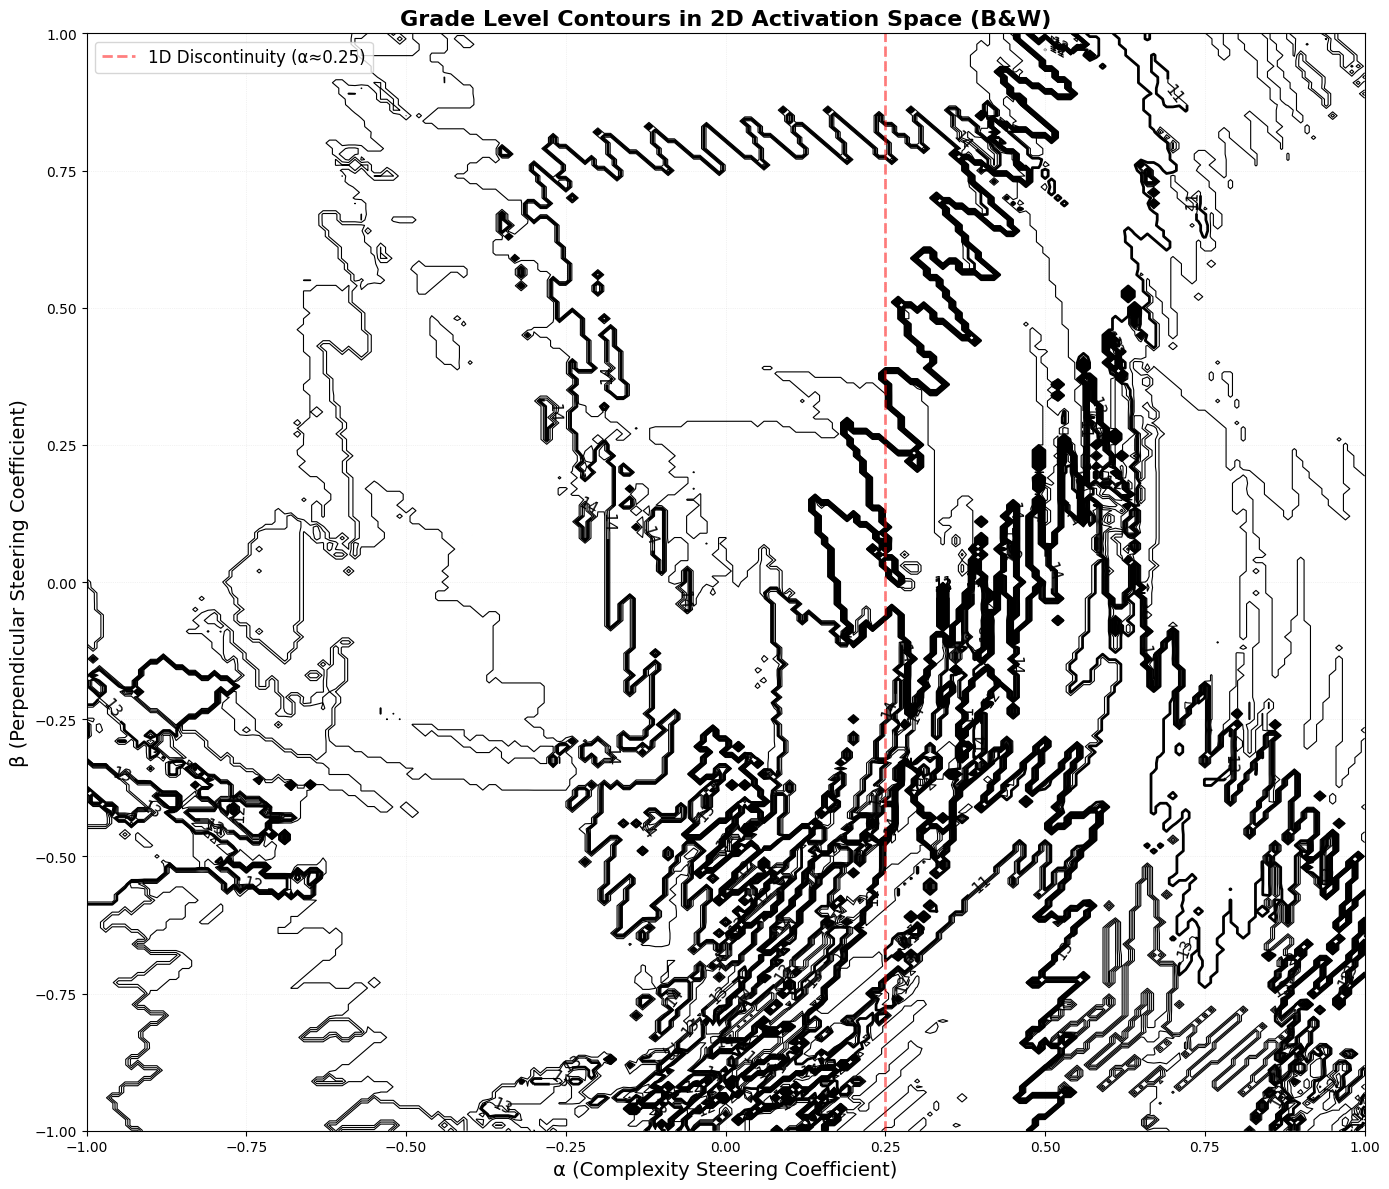


Contour spacing: 0.2 grade levels (fine lines)
Major contours: 10, 11, 12, 13, 14, 15 (thick lines)

Where contours are close together = steep gradient (discontinuity)
Where contours are far apart = gentle gradient (stable regime)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data from CSV
df = pd.read_csv('data/2d_grid_results.csv')

print(f"Loaded {len(df)} data points from CSV")
print(f"Alpha range: [{df['alpha'].min():.2f}, {df['alpha'].max():.2f}]")
print(f"Beta range: [{df['beta'].min():.2f}, {df['beta'].max():.2f}]")
print(f"Grade level range: [{df['flesch_kincaid_grade'].min():.2f}, {df['flesch_kincaid_grade'].max():.2f}]\n")

# Reshape data for contour plot
pivot = df.pivot(index='beta', columns='alpha', values='flesch_kincaid_grade')
X = pivot.columns.values
Y = pivot.index.values
X_grid, Y_grid = np.meshgrid(X, Y)
Z = pivot.values

# Create black and white contour plot
fig, ax = plt.subplots(figsize=(14, 12))

# Many contour lines to show all the detail
# Use smaller intervals to capture the jaggy structure
levels = np.arange(10, 15.5, 0.2)  # Contour every 0.2 grade levels
contour_lines = ax.contour(X_grid, Y_grid, Z, levels=levels, 
                           colors='black', linewidths=0.8)

# Add thicker lines at integer grade levels for reference
major_levels = [10, 11, 12, 13, 14, 15]
major_contours = ax.contour(X_grid, Y_grid, Z, levels=major_levels, 
                            colors='black', linewidths=2)
ax.clabel(major_contours, inline=True, fontsize=11, fmt='%0.0f')

# Mark the 1D discontinuity location
ax.axvline(0.25, color='red', linestyle='--', linewidth=2, alpha=0.5, 
          label='1D Discontinuity (α≈0.25)')

# Labels and formatting
ax.set_xlabel('α (Complexity Steering Coefficient)', fontsize=14)
ax.set_ylabel('β (Perpendicular Steering Coefficient)', fontsize=14)
ax.set_title('Grade Level Contours in 2D Activation Space (B&W)', fontsize=16, fontweight='bold')

# Legend
ax.legend(loc='upper left', fontsize=12)

# Light grid for easier coordinate reading
ax.grid(True, alpha=0.2, linestyle=':', linewidth=0.5, color='gray')

# White background
ax.set_facecolor('white')

plt.tight_layout()
plt.show()

print(f"\nContour spacing: 0.2 grade levels (fine lines)")
print(f"Major contours: 10, 11, 12, 13, 14, 15 (thick lines)")
print(f"\nWhere contours are close together = steep gradient (discontinuity)")
print(f"Where contours are far apart = gentle gradient (stable regime)")